# Playing around with DSP for Bat Calls 
This is a jupyter notebook that imports some audio files with  bat calls in them and attempts to use DSP techniques to isolate the bat call signals by using band pass filtering. 

In [1]:
import numpy as np
import os
import csv
import pandas as pd

from scipy import signal
from scipy.stats import zscore
from scipy.signal import spectrogram
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy.signal as scipy_signal
# import scipy.signal import welch 

import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt

### Import Data

In [2]:
datapath = "./Data/"
x, fs = sf.read(datapath + '20190617_080000.WAV')
# 20190619_145000.WAV 
# 20190622_182000.WAV

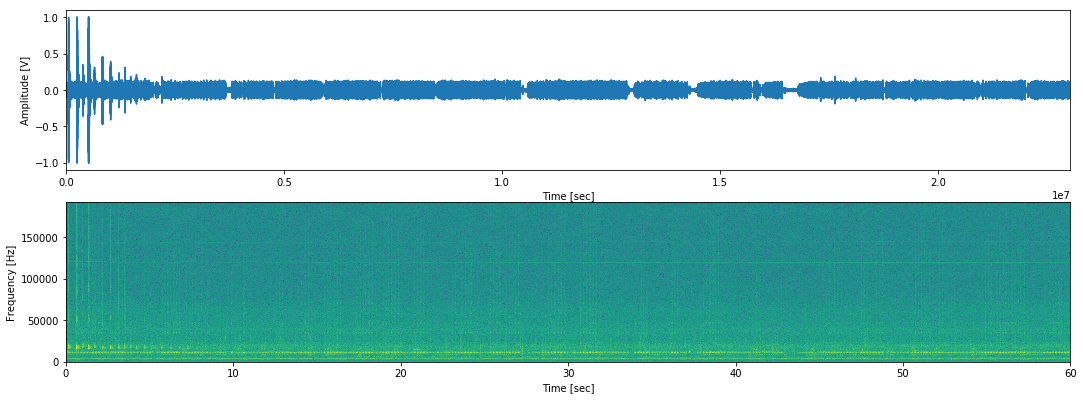

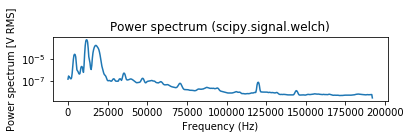

In [3]:
# x = zscore(x) # Why do I need the zscore?

def plot_spectrogram(filename): 
    datapath = "./Data/" # Set here
    x, fs = sf.read(datapath + filename)
    
    nfft = 1024 # allowed values = {64, 128, 256, 512, 1024, 2048}
    # Power spectral density 
    f, t, Pxx = spectrogram(x, fs, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')
    plt.figure(figsize=(18,10))
    
    plt.subplot(3,1,1)
    plt.plot(x)
    plt.xlim([0,len(x)])
    plt.ylabel('Amplitude [V]')
    plt.xlabel('Time [sec]')

    plt.subplot(3,1,2)
    plt.pcolormesh(t, f, np.log(Pxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # cb = plt.colorbar() # uncomment to see the colorbar
    # cb.set_label('Power Spectral Density [dB]')
    plt.show()
    
    plt.subplot(3,1,3)
#     f, Pxx_den = signal.welch(x, fs, nperseg=1024)
    f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
#     plt.xlim([0,5000])
    plt.semilogy(f, Pxx_spec)
    plt.ylabel('Power spectrum [V RMS]')
    plt.xlabel('Frequency (Hz)')
    plt.title('Power spectrum (scipy.signal.welch)')
    
    plt.show()

# Example
plot_spectrogram('20190617_080000.WAV') 

### Band Pass Filter
Bat echolocation calls vary between 5kHz to 210kHz according to Vassilios Stathopoulos (2018): Bat echolocation call identification for biodiversity monitoring. 

In [4]:
### FILTERING FUNCTIONS ###
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Before: 
20190619_145000.WAV


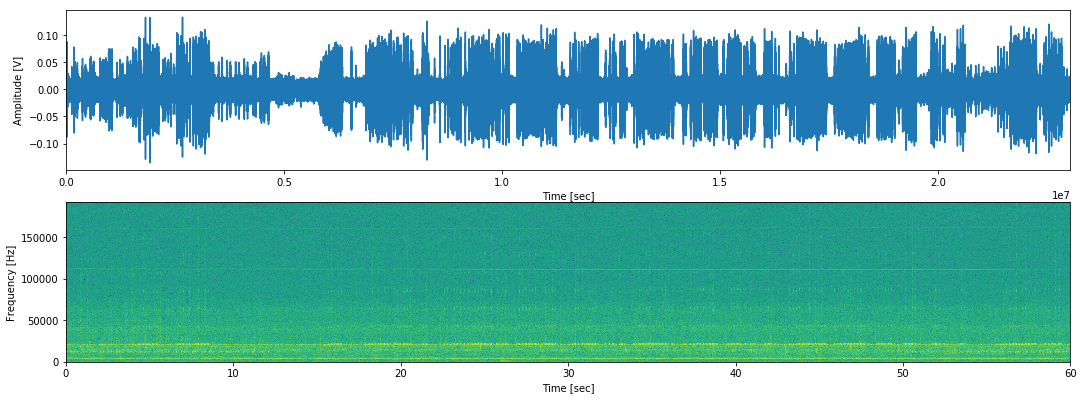

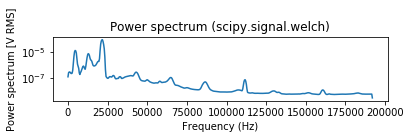

After: 
20190619_145000.WAV


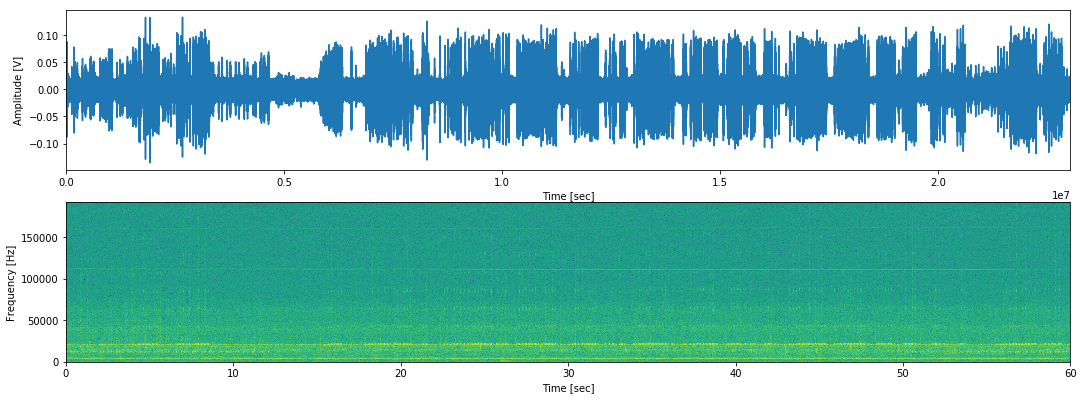

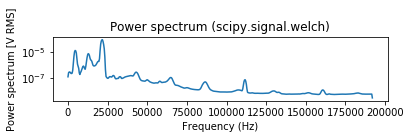

Before: 
20190617_080000.WAV


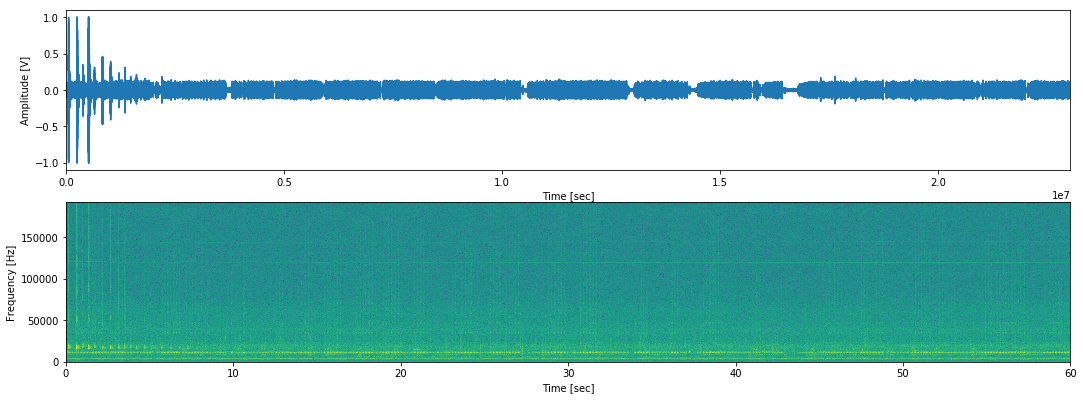

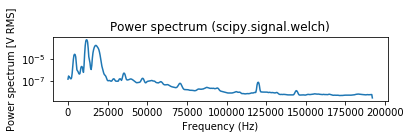

After: 
20190617_080000.WAV


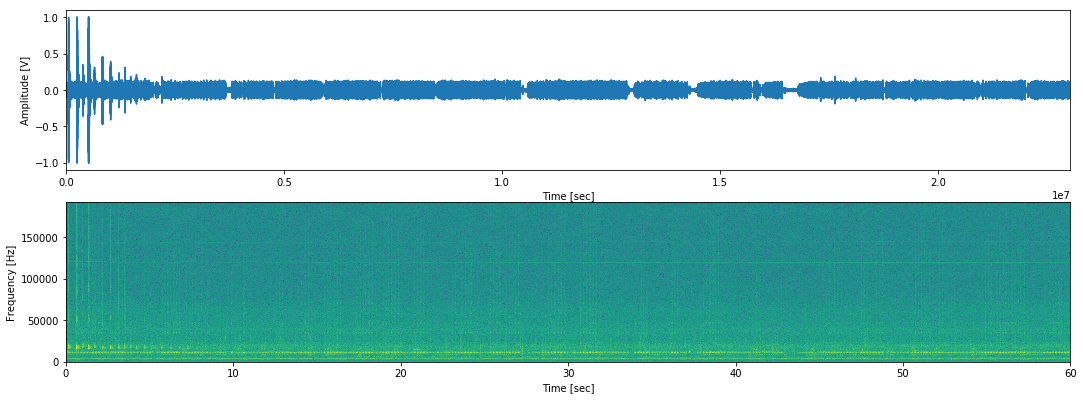

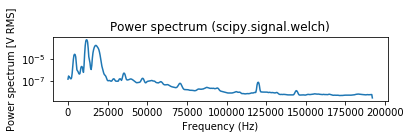

Before: 
20190622_182000.WAV


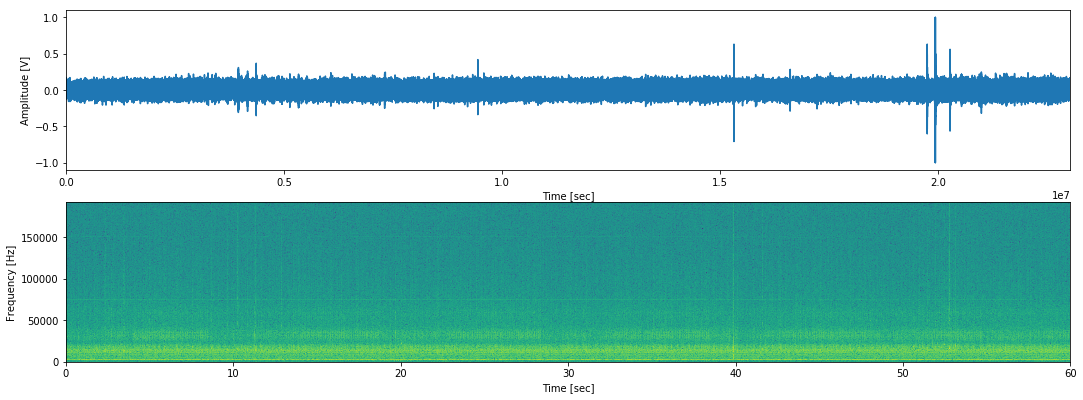

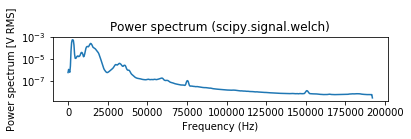

After: 
20190622_182000.WAV


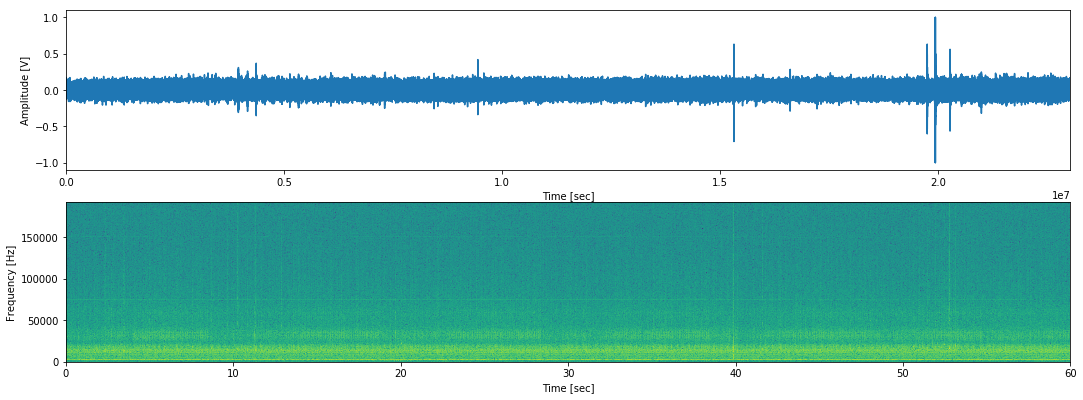

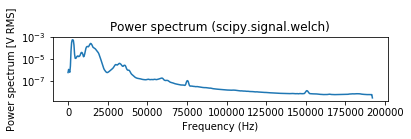

In [5]:
from __future__ import division

downsampling_rate = 44100
original_rate = 384000
rate_ratio = original_rate/downsampling_rate

datapath = "./Data/"
listing = os.listdir(datapath)

### EACH FILE ###
# Band pass through each file and then download those files into a different folder 
# Store spectrograms somewhere... 
# Make spectrograms out of them and input these images into a CNN 

for file in listing:
    print("Before: ")
    print(file)
    plot_spectrogram(file)
    
    x, fs = sf.read(datapath + file)
# #     x = zscore(x) 

#     # Sample rate and desired cutoff frequencies (in Hz).
    
#     # fs needs to be at least 2 x Wn
#     # 191kHz limit due to Nyquist frequency 
#     x = butter_bandpass_filter(x, 5000, 191000, fs, order=5) 

#     ### DOWNSAMPLING ### 
#     # 2) Scipy's built in resample function 
#     # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
#     x = scipy_signal.resample(x, int(len(x)*rate_ratio))
    
    print("After: ")
    print(file)
    plot_spectrogram(file)

# Try plotting the power plot

### Save file ###

### Converting audiofiles into acceptable inputs for ML techniques

In [ ]:
import librosa
import numpy
import skimage
import pkg_resources
from setuptools.py31compat import iter_entry_points

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = numpy.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(numpy.uint8)
    img = numpy.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

if __name__ == '__main__':
    # settings
    hop_length = 512 # number of samples per time-step in spectrogram
    n_mels = 128 # number of bins in spectrogram. Height of image
    time_steps = 384 # number of time-steps. Width of image

    # load audio. Using example from librosa
    path = librosa.util.example_audio_file()
    y, sr = librosa.load(path, offset=1.0, duration=10.0, sr=22050)
    out = 'out.png'

    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = time_steps*hop_length
    window = y[start_sample:start_sample+length_samples]

    # convert to PNG
    spectrogram_image(window, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)
    print('wrote file', out)

In [8]:
### SAVING SPECTROGRAMS ### 
datapath = "./Data/"

x, fs = sf.read(datapath + '20190617_080000.WAV')
listing = os.listdir(datapath)

for file in listing: 
    fig = plt.subplot(nrows = 1, ncols=1)
    f, t, Pxx = spectrogram(x, fs, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')
    plt.pcolormesh(t, f, np.log(Pxx))
    fig.savefig('./Spectrograms')

AttributeError: Unknown property nrows

<Figure size 432x288 with 0 Axes>

In [3]:
### IMPORT CSV ###
df = pd.read_csv('id.csv')

### WANT TO LOOK FOR A SPECIFIC SPECIES? ###
match = df.loc[(df['AUTO ID*'] == 'EPTFUR'), ['IN FILE', 'Fmax', 'Fmin', 'Fmean']] 
# If I want to keep track of more rows, 'B' becomes ['B' 'C']
# If I want multiple conditions to be met: 
# df.loc[(df['A'] == x) & (df['D'] == y), ['B','C',...]]

### LIST ALL THE SPECIES IN THE CSV ### 
# Reference: https://pubs.usgs.gov/of/2018/1068/ofr20181068.pdf
species_list = df['AUTO ID*'].unique()
print(species_list)
# txt file of all the species 

### DOWNLOAD ###
match.to_csv(r'filenames.txt',sep=' ', index = False, columns = ['IN FILE'], header = False)
file = open('./filenames.txt')
filename = file.readline() 
while filename: 
    filename = file.readline()

['CENCEN' 'DICALB' 'EPTBRA' 'EPTFUR' 'EUMGLA' 'EUMPER' 'LASBLO' 'LASCIN'
 'LASEGA' 'MOLMOL' 'MOLRUF' 'MOLTEM' 'MORMEG' 'MYOKEA' 'MYONIG' 'MYORIP'
 'NYCLAT' 'NYCMAC' 'NoID' 'PERKAP' 'PERMAC' 'PROCEN' 'PTEDAV' 'PTEPAR'
 'PTEPER' 'RHYNAS' 'SACBIL' 'SACLEP' 'TADBRA']


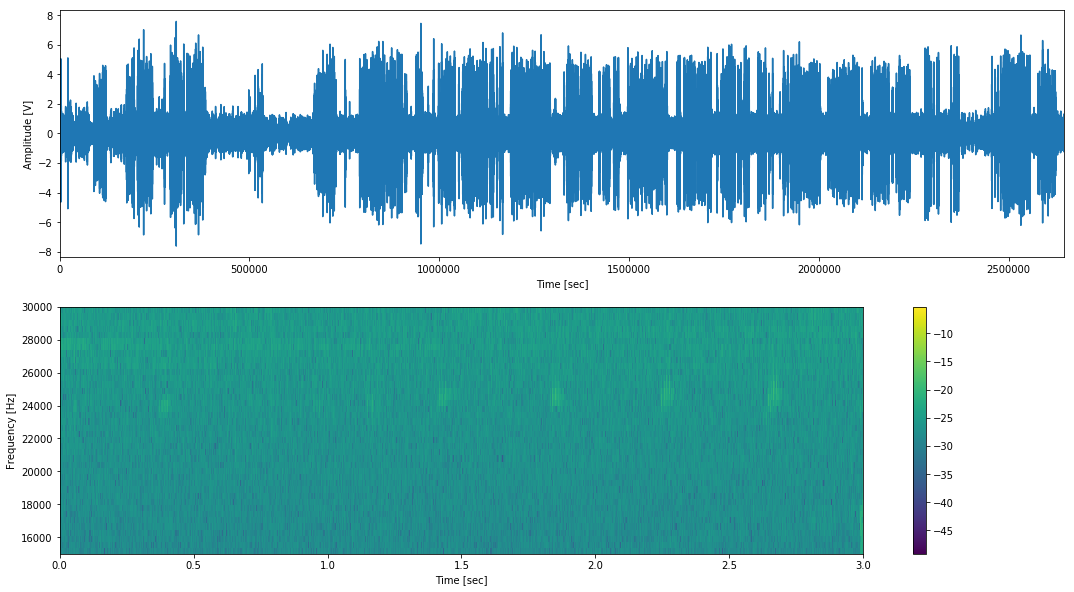

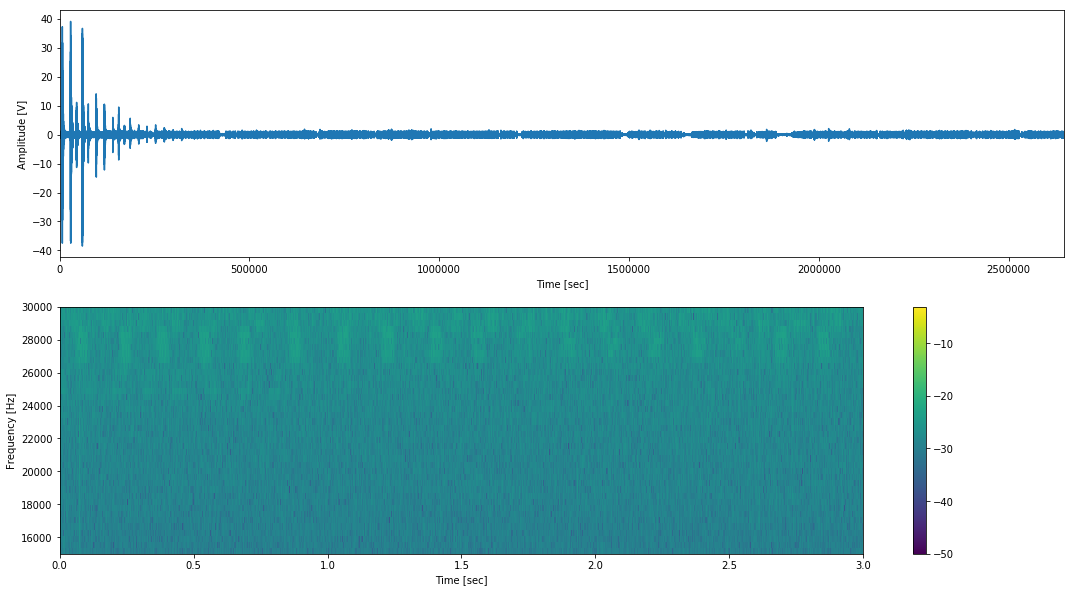

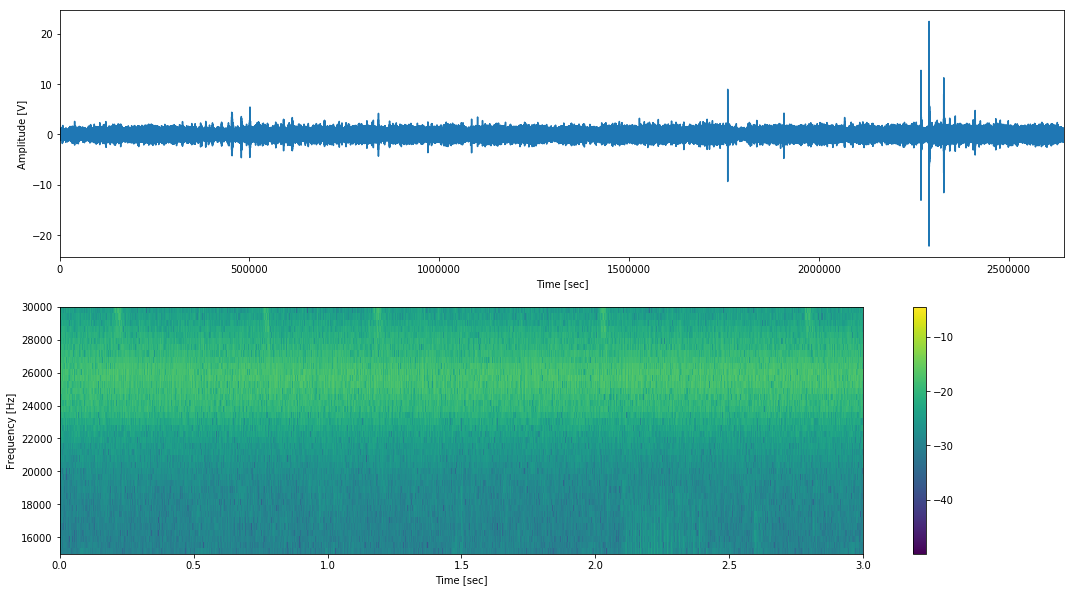

In [32]:
downsampling_rate = 44100
original_rate = 384000
rate_ratio = downsampling_rate/original_rate 

datapath = "./EPTFUR/"
x, fs = sf.read(datapath + '20190617_080000.WAV')
listing = os.listdir(datapath)

### EACH FILE ###
# Band pass through each file and then download those files into a different folder 
# Store spectrograms somewhere... 
# 
# Make spectrograms out of them and input these images into a CNN 


for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 

    # Sample rate and desired cutoff frequencies (in Hz).
    lowcut = 15000
    highcut = 30000
    x = butter_bandpass_filter(x, lowcut, highcut, fs, order=2)

    ### DOWNSAMPLING ### 
    # 2) Scipy's built in resample function 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
    x = scipy_signal.resample(x, int(len(x)*rate_ratio))
    
    nfft = 1024 # allowed values = {64, 128, 256, 512, 1024, 2048}

    # Power spectral density 
    f, t, Pxx = spectrogram(x, fs, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')
    
    x_reduced = np.divide(x, 10)
    sd.play(x, fs)
    sd.wait()
    
    plt.figure(figsize=(18,10))

    plt.subplot(2,1,1)
    plt.plot(x)
    plt.xlim(0, len(x))
    plt.ylabel('Amplitude [V]')
    plt.xlabel('Time [sec]')

    plt.subplot(2,1,2)
    plt.ylim([lowcut, highcut])
    plt.xlim([0, 3])
    plt.pcolormesh(t, f, np.log(Pxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    cb = plt.colorbar() # uncomment to see the colorbar
    # cb.set_label('Power Spectral Density [dB]')
    plt.show()

### Save file ###

In [37]:
import librosa 
import pyrubberband 
y, sr = librosa.load(filepath, sr=None)
y_stretched = pyrubberband.time_stretch(y, sr, 0.5)
sd.play(y_stretched, sr)
sd.wait()

AttributeError: module 'numba' has no attribute 'core'

### Downsampling
Since the original sampling rate of the files are at 384kHz but most researched pipelines use sampling rates at 44.1kHz.